In [5]:
!pip install transformers

In [6]:
import pandas as pd

In [7]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForMaskedLM, TFBertModel

bert_tokenizer = AutoTokenizer.from_pretrained("l3cube-pune/tamil-bert")
bert_model = TFBertModel.from_pretrained("l3cube-pune/tamil-bert")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'bert.embeddings.position_ids', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertModel were not initialized from the PyTorch model and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-

In [8]:
data = pd.read_excel('dataset_final.xlsx')
data.head()

,Column1,English Version,Label,News,Author,Date,Authenticity
0,0,Additional charge for users who share password...,tech,பாஸ்வேர்டை பகிரும் பயனர்களிடம் கூடுதல் கட்டணம...,செய்திப்பிரிவு,2022-10-19,0
1,1,Production of 'AK-203' guns in India by the en...,tech,இந்தியாவில் நடப்பு ஆண்டின் இறுதிக்குள் ‘ஏகே-2...,செய்திப்பிரிவு,2022-10-18,0
2,2,Moto E22s smartphone launched in India at a bu...,tech,பட்ஜெட் விலையில் மோட்டோ E22s ஸ்மார்ட்போன் இந்...,செய்திப்பிரிவு,2022-10-17,0
3,3,Let's make Kalam's last dream come true,tech,கலாம் கண்ட கடைசி கனவை நனவாக்குவோம்,செய்திப்பிரிவு,2022-10-15,0
4,4,Redmi A1+ smartphone launched in India at a bu...,tech,பட்ஜெட் விலையில் ரெட்மி ஏ1+ ஸ்மார்ட்போன் இந்த...,செய்திப்பிரிவு,2022-10-14,0


In [9]:
import string
import re
from sklearn.model_selection import train_test_split

data['News']= data['News'].apply(lambda x:re.sub(r'http\S+', '', x))
data['News']= data['News'].apply(lambda x:re.sub(r'@\S+ ', '', x))
data['News']= data['News'].apply(lambda x:''.join(i for i in x if not i.isdigit()))
table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
data['News']= data['News'].str.translate(table)
data['News']= data['News'].str.replace(' +', ' ')
data['News']= data['News'].str.lower()
data['News']= data['News'].str.strip()

<ipython-input-9-be84f72caf79>:10: FutureWarning: The default value of regex will change from True to False in a future version.
  data['News']= data['News'].str.replace(' +', ' ')


In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(data['News'], data['Authenticity'], stratify = data['Authenticity'], test_size = 0.2, random_state =42)

In [11]:
def tokenize(X):
    X = bert_tokenizer(
        text = list(X),
        add_special_tokens = True,
        max_length = 100,
        truncation = True,
        padding = 'max_length',
        return_tensors = 'tf',
        return_token_type_ids = False,
        return_attention_mask = True,
        verbose = True
        )
    return X

In [12]:
X_train_token = tokenize(X_train)
X_test_token = tokenize(X_test)

In [13]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,Input
from tensorflow.keras.models import Model, Sequential
import tensorflow as tf

In [14]:
def create_model(maxlen, bert_model):
    dropout_rate = 0.3

    # Define input layers
    input_ids = Input(shape=(maxlen,), dtype=tf.int32, name="input_ids")
    input_mask = Input(shape=(maxlen,), dtype=tf.int32, name="attention_mask")

    for layer in bert_model.layers:
        layer.trainable = True

    # Create a dictionary of inputs for the BERT model
    bert_inputs = {
        "input_ids": input_ids,
        "attention_mask": input_mask,
    }

    # Pass the inputs to the BERT model
    bert_output = bert_model(bert_inputs)[1]  # Use [1] to get the pooled output

    # Additional layers for classification
    x = Dropout(dropout_rate)(bert_output)
    x = Dense(64, activation="tanh")(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(1, activation="sigmoid")(x)

    # Create the model
    model = Model(inputs=[input_ids, input_mask], outputs=x)
    return model

In [15]:
model1=create_model(100,bert_model)
model2=create_model(100,bert_model)
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask (InputLayer  [(None, 100)]                0         []                            
 )                                                                                                
                                                                                                  
 input_ids (InputLayer)      [(None, 100)]                0         []                            
                                                                                                  
 tf_bert_model_1 (TFBertMod  TFBaseModelOutputWithPooli   2375562   ['attention_mask[0][0]',      
 el)                         ngAndCrossAttentions(last_   24         'input_ids[0][0]']           
                             hidden_state=(None, 100, 7                                       

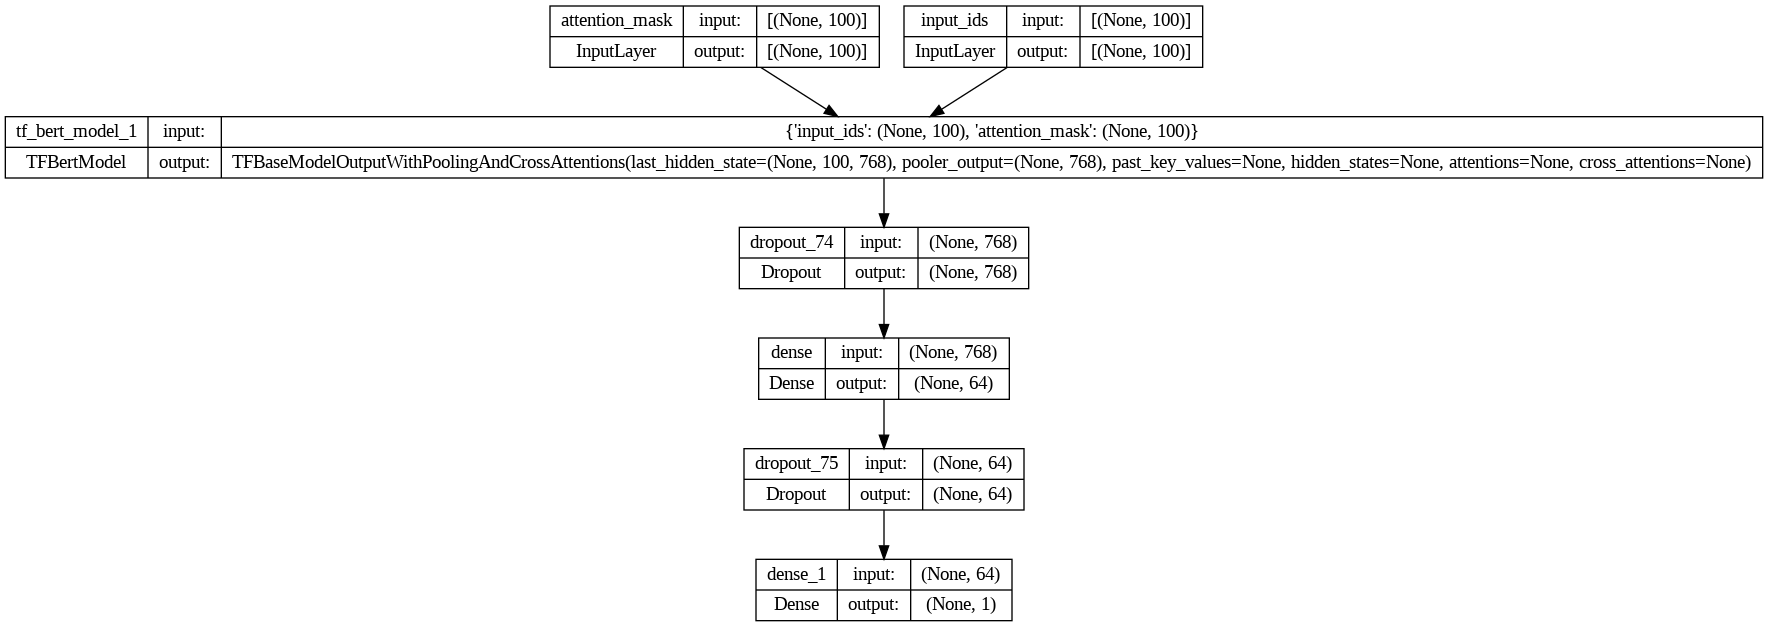

In [16]:
from tensorflow.keras.utils import plot_model
plot_model(model1, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


In [17]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=1e-05, epsilon=1e-08,clipnorm=1.0)
model1.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = 'accuracy')

In [18]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='max', verbose=1, patience=3,baseline=0.4,min_delta=0.0001,restore_best_weights=True)
history1 = model1.fit(x = {'input_ids':X_train_token['input_ids'],'attention_mask':X_train_token['attention_mask']}, y = Y_train, epochs=5, validation_split = 0.2, batch_size = 30, callbacks=[callback])

Epoch 1/5
112/112 [==============================] - 148s 750ms/step - loss: 0.5997 - accuracy: 0.7380 - val_loss: 0.3894 - val_accuracy: 0.9354
Epoch 2/5
112/112 [==============================] - 80s 713ms/step - loss: 0.2825 - accuracy: 0.9578 - val_loss: 0.1805 - val_accuracy: 0.9665
Epoch 3/5
112/112 [==============================] - 81s 723ms/step - loss: 0.1350 - accuracy: 0.9794 - val_loss: 0.1125 - val_accuracy: 0.9713
Epoch 3: early stopping


In [19]:
from matplotlib import pyplot as plt


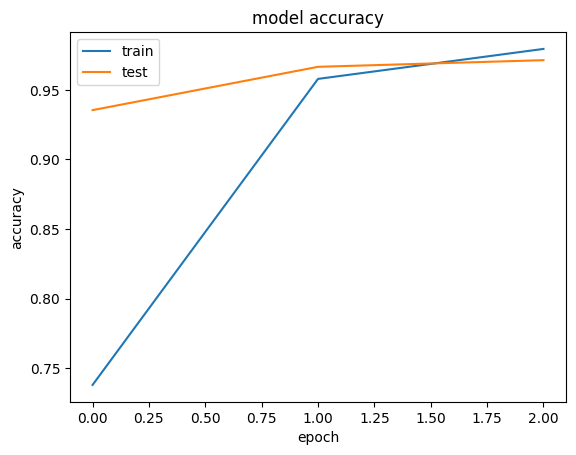

In [20]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

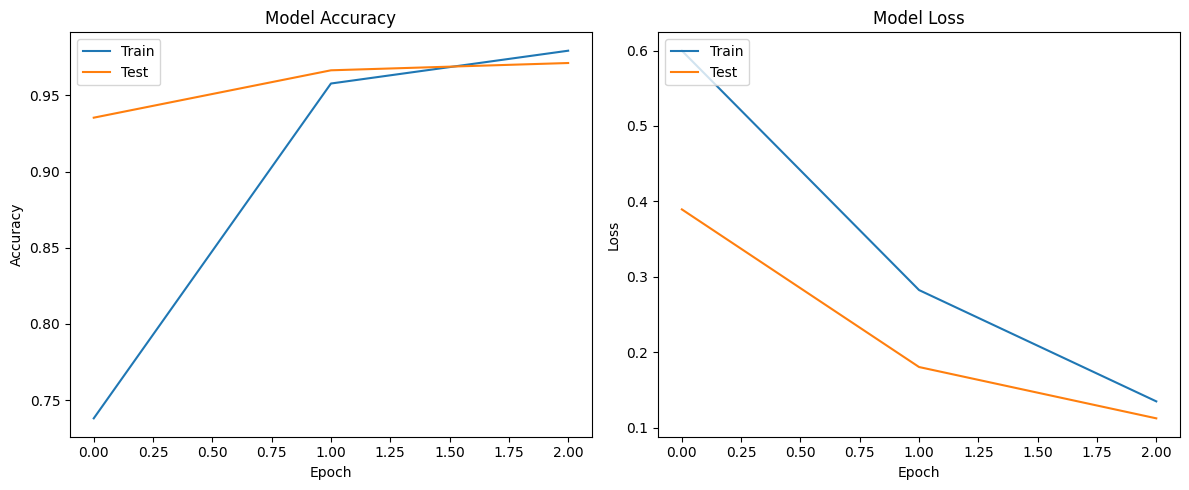

In [21]:
import matplotlib.pyplot as plt

# Assuming you have a 'history' object from your model training
# history = model.fit(...)

# Plot accuracy and loss side by side
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()


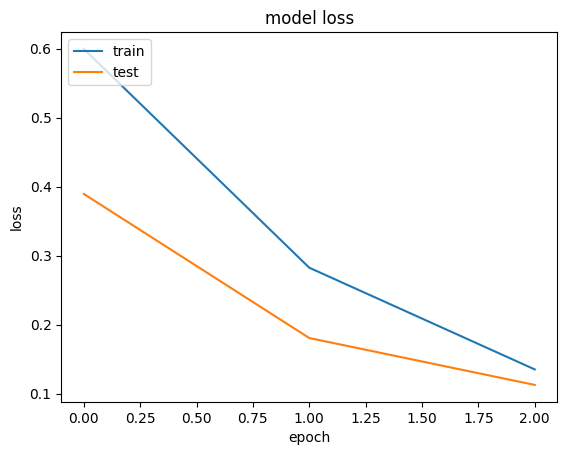

In [22]:
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
import numpy as np
y_pred = np.where(model1.predict({ 'input_ids' : X_test_token['input_ids'] , 'attention_mask' : X_test_token['attention_mask']}) >=0.5,1,0)

33/33 [==============================] - 11s 208ms/step


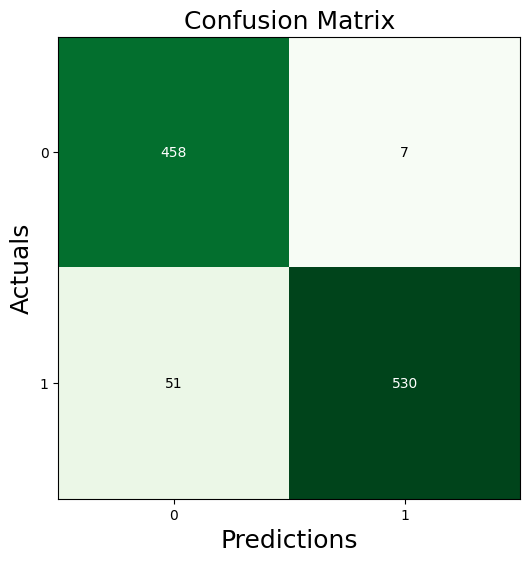

In [24]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(Y_test,y_pred)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [25]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       465
           1       0.99      0.91      0.95       581

    accuracy                           0.94      1046
   macro avg       0.94      0.95      0.94      1046
weighted avg       0.95      0.94      0.94      1046



In [26]:
test_text='எனது படம் ஆஸ்கார் விருதுக்கு தகுதியானது - நடிகர் மாதவன்'
test_token = tokenize(test_text)
test_text_pred = np.where(model1.predict({ 'input_ids' : test_token['input_ids'] , 'attention_mask' : test_token['attention_mask']}) >=0.5,1,0)

2/2 [==============================] - 0s 160ms/step


In [27]:
test_text_pred

array([[0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0]])

In [28]:
if(test_text_pred[0]==0):
    print("News is Fake")
else:
    print("News is Real")

News is Fake



# K- fold cross validation

In [29]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Define the number of folds for cross-validation
num_folds = 5

# Initialize a StratifiedKFold object for stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize a list to store accuracy scores for each fold
accuracies = []

# Iterate over the folds
for train_index, test_index in skf.split(data['News'], data['Authenticity']):
    # Split the data into training and testing sets for this fold
    kX_train, kX_test = data['News'].iloc[train_index], data['News'].iloc[test_index]
    ky_train, ky_test = data['Authenticity'].iloc[train_index], data['Authenticity'].iloc[test_index]

    kX_train_token=tokenize(kX_train)
    kX_test_token= tokenize(kX_test)

    # Make predictions on the test data
    y_pred = np.where(model1.predict({ 'input_ids' : kX_test_token['input_ids'] , 'attention_mask' : kX_test_token['attention_mask']})>=0.5,1,0)

    # Calculate accuracy for this fold
    accuracy = accuracy_score(ky_test, y_pred)
    accuracies.append(accuracy)

# Calculate the average accuracy across all folds
print(accuracies)
average_accuracy = np.mean(accuracies)

# Print the average accuracy
print("Average Accuracy:", average_accuracy)


33/33 [==============================] - 7s 217ms/step
[0.9321223709369025, 0.9435406698564593, 0.938755980861244, 0.9473684210526315, 0.9502392344497608]
Average Accuracy: 0.9424053354313997


In [30]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import StratifiedKFold
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score

# # Load your dataset
# # Assuming you have a DataFrame 'data' with columns 'News' and 'Authenticity'
# # 'News' contains the news text, and 'Authenticity' contains binary labels (1 for authentic, 0 for fake)

# # Define a range of values for k (number of folds)
# k_values = list(range(2, 25))  # You can adjust this list to include other values

# # Initialize a dictionary to store average accuracies for each value of k
# average_accuracies = {}

# # Iterate over different values of k
# for num_folds in k_values:
#     # Initialize a StratifiedKFold object for stratified k-fold cross-validation
#     skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

#     # Initialize a list to store accuracy scores for each fold
#     accuracies = []

#     # Iterate over the folds
#     for train_index, test_index in skf.split(data['News'], data['Authenticity']):
#         # Split the data into training and testing sets for this fold
#         kX_train, kX_test = data['News'].iloc[train_index], data['News'].iloc[test_index]
#         ky_train, ky_test = data['Authenticity'].iloc[train_index], data['Authenticity'].iloc[test_index]

#         kX_train_token = tokenize(kX_train)
#         kX_test_token = tokenize(kX_test)

#         # Make predictions on the test data
#         y_pred = np.where(model.predict({'input_ids': kX_test_token['input_ids'], 'attention_mask': kX_test_token['attention_mask']}) >= 0.5, 1, 0)

#         # Calculate accuracy for this fold
#         accuracy = accuracy_score(ky_test, y_pred)
#         accuracies.append(accuracy)

#     # Calculate the average accuracy across all folds for this value of k
#     average_accuracy = np.mean(accuracies)

#     # Store the average accuracy in the dictionary
#     average_accuracies[num_folds] = average_accuracy

# # Find the best value of k based on average accuracy
# best_k = max(average_accuracies, key=average_accuracies.get)
# best_accuracy = average_accuracies[best_k]

# # Print the average accuracies for different values of k and the best k
# print("Average Accuracies for Different Values of k:")
# for k, accuracy in average_accuracies.items():
#     print(f"k = {k}: {accuracy}")

# print(f"Best k: {best_k} (Accuracy: {best_accuracy})")


In [31]:
# plt.plot(k_values, average_accuracies.values())
# plt.xlabel('Value of K for model')
# plt.ylabel('Cross-Validated-Accuracy')

# New Dataset

In [32]:
test_df1 = pd.read_excel('ta_fake_final.xlsx')
test_df2 = pd.read_excel('ta_true_final.xlsx')
test_df = pd.concat([test_df1, test_df2], ignore_index=True)
test_df.head()

,text,label
0,ஆலங்கட்டி மழை பெய்தது திருத்தணியா… கொடைக்கானலா...,0
1,தூத்துக்குடியில் போலீசார் துப்பாக்கியால் சுடும...,0
2,பெண்கள் கால் மேல் கால் போட்டு அமர்ந்தால் கர்ப்...,0
3,பெரிய வீட்டுப் பிள்ளைகள் தப்பு செய்வது சகஜம் எ...,0
4,குடியுரிமை திருத்தச் சட்டத்தை எதிர்ப்பவர்களை ந...,0


In [33]:
test_df.tail()

,text,label
6276,பவானி வைகை முல்லைப்பெரியாறு தாமிரபரணி ஆறுகளில்...,1
6277,சென்னை கொரோனாவின் தாக்கம் நாளுக்கு நாள் அதிகரி...,1
6278,இங்கிலாந்திலும் கல்வித்துறை இணைய தளங்களிலும் ச...,1
6279,நோய் பரவலைக் கட்டுப்படுத்த கோவில் வளாகத்திற்கு...,1
6280,ஆதி சங்கரரை பின்பற்றக்கூடிய இவர்கள் இறைவனை எந்...,1


In [34]:
test_df['text']= test_df['text'].apply(lambda x:re.sub(r'http\S+', '', x))
test_df['text']= test_df['text'].apply(lambda x:re.sub(r'@\S+ ', '', x))
test_df['text']= test_df['text'].apply(lambda x:''.join(i for i in x if not i.isdigit()))
table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
test_df['text']= test_df['text'].str.translate(table)
test_df['text']= test_df['text'].str.replace(' +', ' ')
test_df['text']= test_df['text'].str.lower()
test_df['text']= test_df['text'].str.strip()

<ipython-input-34-170dc66c0c86>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  test_df['text']= test_df['text'].str.replace(' +', ' ')


In [35]:
test_df = test_df.dropna()

In [36]:
test_X_train, test_X_test, test_Y_train, test_Y_test = train_test_split(test_df['text'], test_df['label'], stratify = test_df['label'], test_size = 0.2, random_state =42)

In [37]:
test_X_train_token = tokenize(test_X_train)
test_X_test_token = tokenize(test_X_test)

In [38]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=1e-05, epsilon=1e-08,clipnorm=1.0)
model2.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = 'accuracy')
history2= model2.fit(x = {'input_ids':test_X_train_token['input_ids'],'attention_mask':test_X_train_token['attention_mask']}, y = test_Y_train, epochs=5, validation_split = 0.2, batch_size = 16, callbacks=[callback])

Epoch 1/5
252/252 [==============================] - 160s 459ms/step - loss: 0.4405 - accuracy: 0.8803 - val_loss: 0.1904 - val_accuracy: 0.9642
Epoch 2/5
252/252 [==============================] - 104s 412ms/step - loss: 0.1443 - accuracy: 0.9694 - val_loss: 0.1097 - val_accuracy: 0.9632
Epoch 3/5
252/252 [==============================] - 104s 412ms/step - loss: 0.0683 - accuracy: 0.9853 - val_loss: 0.1041 - val_accuracy: 0.9692
Epoch 3: early stopping


In [39]:
len(test_X_train)

5024

In [40]:
print(len(test_X_train_token['input_ids']))
print(len(test_X_train_token['attention_mask']))
print(len(test_Y_train))

5024
5024
5024


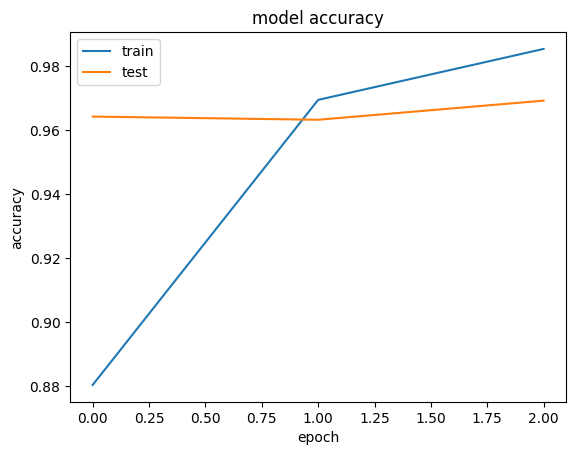

In [41]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

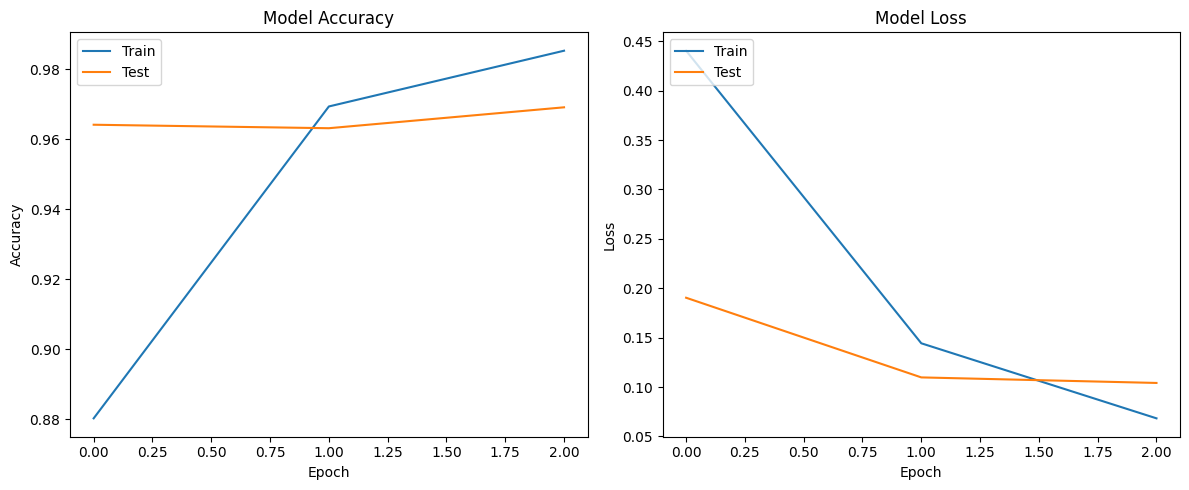

In [42]:
import matplotlib.pyplot as plt

# Assuming you have a 'history' object from your model training
# history = model.fit(...)

# Plot accuracy and loss side by side
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()


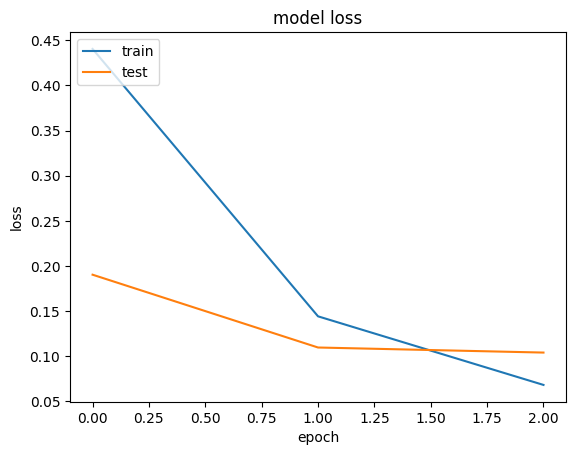

In [43]:
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [44]:
test_y_pred = np.where(model2.predict({ 'input_ids' : test_X_test_token['input_ids'] , 'attention_mask' : test_X_test_token['attention_mask']}) >=0.5,1,0)

40/40 [==============================] - 11s 208ms/step


In [45]:
print(len(test_Y_test))
print(len(test_y_pred))
print(len(test_X_test))

1257
1257
1257


In [46]:
# test_Y_test = test_Y_test.tolist()
# test_y_pred = test_y_pred.tolist()
# len(test_Y_test)
# # Ensure that both lists have the same length
# if len(test_Y_test) == len(test_y_pred):
#     conf_matrix = confusion_matrix(test_Y_test, test_y_pred)
#     fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Greens)
#     plt.xlabel('Predictions', fontsize=18)
#     plt.ylabel('Actuals', fontsize=18)
#     plt.title('Confusion Matrix', fontsize=18)
#     plt.show()
# else:
#     print("Error: Arrays have different lengths.")

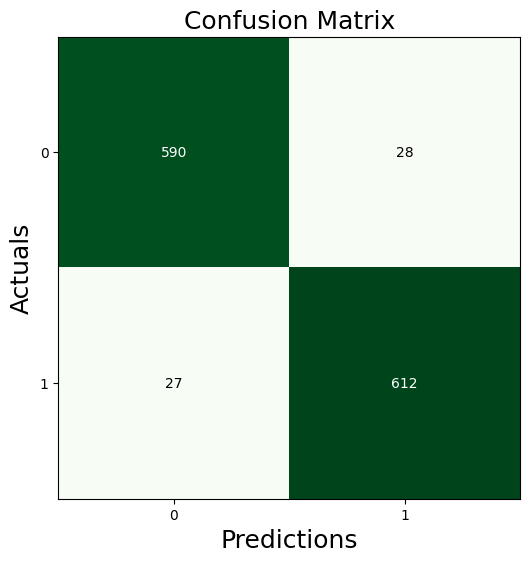

In [47]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(test_Y_test,test_y_pred)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [48]:
from sklearn.metrics import classification_report
print(classification_report(test_Y_test,test_y_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       618
           1       0.96      0.96      0.96       639

    accuracy                           0.96      1257
   macro avg       0.96      0.96      0.96      1257
weighted avg       0.96      0.96      0.96      1257



In [49]:
# Define the number of folds for cross-validation
num_folds = 5

# Initialize a StratifiedKFold object for stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize a list to store accuracy scores fors each fold
test_accuracies = []

# Iterate over the folds
for train_index, test_index in skf.split(test_df['text'], test_df['label']):
    # Split the data into training and testing sets for this fold
    kX_train, kX_test = test_df['text'].iloc[train_index], test_df['text'].iloc[test_index]
    ky_train, ky_test = test_df['label'].iloc[train_index], test_df['label'].iloc[test_index]

    kX_train_token=tokenize(kX_train)
    kX_test_token= tokenize(kX_test)

    # Make predictions on the test data
    y_pred = np.where(model2.predict({ 'input_ids' : kX_test_token['input_ids'] , 'attention_mask' : kX_test_token['attention_mask']})>=0.5,1,0)

    # Calculate accuracy for this fold
    accuracy = accuracy_score(ky_test, y_pred)
    test_accuracies.append(accuracy)

# Calculate the average accuracy across all folds
print(test_accuracies)
average_accuracy = np.mean(test_accuracies)

# Print the average accuracy
print("Average Accuracy:", average_accuracy)


40/40 [==============================] - 9s 214ms/step
[0.9665871121718377, 0.9721337579617835, 0.964968152866242, 0.9705414012738853, 0.964968152866242]
Average Accuracy: 0.9678397154279981
